In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads=4
from torch import nn

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy
import scipy.io

np.random.seed(123)

In [2]:
mod = "final_model"

in_dir = f"../data/{mod}/"
fig_dir = f"../figures/{mod}_eval/"

n_eval = 4
n_batch = 4

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
with open(in_dir + "PIPNet_model_pars.pk", "rb") as F:
    model_pars, data_pars = pk.load(F)
model_pars["final_act"] = "sigmoid"

In [5]:
net = model.ConvLSTMEnsemble(**model_pars)
net.load_state_dict(torch.load(in_dir + f"PIPNet_model.weights", map_location=torch.device("cpu")))
net.eval()
print("Model loaded!")

Model loaded!


In [6]:
loss_pars = dict(
    srp_w=1.0,
    srp_exp=2.0,
    srp_offset=1.0,
    srp_fac=0.0,
    brd_w=0.0,
    brd_sig=1.0,
    brd_len=15,
    brd_exp=2.0,
    brd_offset=1.0,
    brd_fac=0.0,
    int_w=0.0,
    int_exp=2.0,
    return_components=False,
)

L = model.CustomLoss(**loss_pars)

In [7]:
def plot_comparison(X, y_pred, y_std, y_trg, show=False, save=None):
    
    x = np.arange(y_trg.shape[-1])
    
    n_samples = y_trg.shape[0]
    
    for i in range(n_samples):
        
        for step in range(y_pred.shape[1]):

            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            ax.set_xlim(0, y_trg.shape[-1])
            ax.set_ylim(-0.02, 1.02)

            ax.plot(X[i, -(y_pred.shape[1]-step), 0] / X[i, -(y_pred.shape[1]-step), 0].max())

            ax.plot(y_trg[i, -1], "k")

            ax.plot(y_pred[i, step], "r")
            ax.fill_between(x, y_pred[i, step] - y_std[i, step], y_pred[i, step] + y_std[i, step],
                            color="r", alpha=0.3, linewidth=0)

            fig.tight_layout()
            if show:
                plt.show()
            if save is not None:
                fig.savefig(save + f"sample_{i+1}_step_{step+1}.pdf")
            plt.close()
    
    return

# Evaluate 1/wr, sharp

In [8]:
data_pars = dict(
    # General parameters
    td=256,  # Number of points
    Fs=12800,  # Sampling frequency
    debug=False,  #  Print data generation details
    # Peak parameters
    pmin=1,  # Minimum number of Gaussians in a peak
    pmax=1,  # Maximum number of Gaussians in a peak
    ds=0.03,  # Spread of chemical shift values for each peak
    lw=[[5e1, 2e2]],  # Linewidth range for Gaussians
    iso_p=[1.],
    iso_p_peakwise=True,
    iso_int=[0.5, 1.0],  # Intensity
    phase=0.0,  # Spread of phase
    # Isotropic parameters
    nmin=1,  # Minimum number of peaks
    nmax=15,  # Maximum number of peaks
    shift_range=[2000.0, 10000.0],  # Chemical shift range
    positive=True,  # Force the spectrum to be positive
    # MAS-independent parameters
    # MAS-independent GLS broadening range
    mas0_lw_range=[0.0, 0.0],
    mas0_lw_p=[1.0],
    # MAS-independent GLS mixing paramter
    mas0_m_range=[[0.0, 0.1], [0.0, 1.0]],
    mas0_m_p=[0.8, 0.2],
    mas0_s_range=[0.0, 0.0],  # MAS-independent shift range
    mas0_s_p=[1.0],
    # MAS-dependent parameters
    # MAS-dependent GLS broadening range
    mas_lw_range=[[1e7, 1e8], [5e7, 2e8]],
    mas_lw_p=[0.8, 0.2],
    mas_m_range=[[1e4, 5e4]],  # MAS-dependent GLS mixing paramter
    mas_m_p=[1.0],
    mas_s_range=[-1.5e7, 1.5e7],  # MAS-dependent shift range
    mas_s_p=[1.0],
    # Second-order MAS-dependent parameters
    mas_w2=False,
    mas_w2_p=1.0,
    # Second-order MAS-dependent Gaussian broadening range
    mas2_lw_range=[[1e2, 1e4], [1e8, 1e9]],
    mas2_lw_p=[0.5, 0.5],
    # Second-order MAS-dependent Lorentzian broadening range
    mas2_m_range=[[0.0, 10], [1e4, 1e6]],
    mas2_m_p=[0.5, 0.5],
    # Second-order MAS-dependent shift range
    mas2_s_range=[[0.0, 0.0], [-2e11, 2e11]],
    mas2_s_p=[0.8, 0.2],
    # Other MAS-dependent mixing
    mas_other_mixing_p=0.5,
    mas_other_mixing_trends=["constant", "increase", "decrease"],
    mas_other_mixing_probs=[0.4, 0.3, 0.3],
    mas_other_mixing_range=[0.0, 1.0],
    # Add noise to linewidths
    mas_lw_noise=0.05,
    mas_s_noise=20.0,
    mas_phase=0.01,  # Random phase range for MAS spectra
    peakwise_phase=True,  # Whether the phase should be peak-wise or spectrum-wise
    encode_imag=False,  # Encode the imaginary part of the MAS spectra
    nw=24,  # Number of MAS rates
    mas_w_range=[30000, 100000],  # MAS rate range
    random_mas=True,
    encode_w=True,  # Encode the MAS rate of the spectra
    # Post-processing parameters
    noise=0.0,  # Noise level
    smooth_end_len=10,  # Smooth ends of spectra
    iso_norm=256.0,  #  Normalization factor for peaks
    brd_norm=64.0,  #  Normalization factor for MAS spectra
    offset=0.0,  # Baseline offset
    norm_wr=True,  # Normalize MAS rate values
    wr_inv=False,  # Encode inverse of MAS rate instead of MAS rate
)

fdir = fig_dir + "sharp_1_w/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [9]:
dataset = data.PIPDatasetGLS(**data_pars)
np.random.seed(123)

In [10]:
Xs = []
ys_trg = []
ys_pred = []

for _ in range(n_batch):
    
    these_Xs = []
    these_ys_trg = []
    
    for _ in range(n_eval):
        X, _, y_trg = dataset.__getitem__(0)
        these_Xs.append(X.unsqueeze(0))
        these_ys_trg.append(y_trg.unsqueeze(0))

    these_Xs = torch.cat(these_Xs)
    these_ys_trg = torch.cat(these_ys_trg)
    
    all_ys = []
    
    with torch.no_grad():
        for i in range(model_pars["batch_input"], data_pars["nw"]+1):
            y_pred, y_std, ys = net(these_Xs[:, :i])
            all_ys.append(ys[:, :, -1:].detach().transpose(0, 1))
        
        
    Xs.append(these_Xs)
    ys_trg.append(these_ys_trg)
    ys_pred.append(torch.cat(all_ys, dim=2))
    
    print(y_pred.shape, y_std.shape, ys.detach().transpose(0, 1).shape)

Xs = torch.cat(Xs)
ys_trg = torch.cat(ys_trg)
ys_pred = torch.cat(ys_pred)
y_pred = torch.mean(ys_pred, dim=1)
y_std = torch.std(ys_pred, dim=1)

torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])


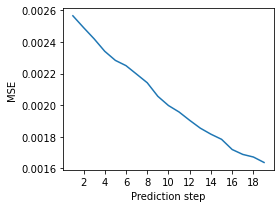

Baseline MSE: 0.00320368
Mean MSE: 0.00299846
average MSE: 0.00204064
Initial MSE: 0.00256566
Final MSE: 0.00163700

Step 1 MSE: 0.00256566
Step 2 MSE: 0.00249145
Step 3 MSE: 0.00241982
Step 4 MSE: 0.00234096
Step 5 MSE: 0.00228335
Step 6 MSE: 0.00225011
Step 7 MSE: 0.00219618
Step 8 MSE: 0.00214185
Step 9 MSE: 0.00205594
Step 10 MSE: 0.00199751
Step 11 MSE: 0.00195651
Step 12 MSE: 0.00190372
Step 13 MSE: 0.00185412
Step 14 MSE: 0.00181595
Step 15 MSE: 0.00178361
Step 16 MSE: 0.00171899
Step 17 MSE: 0.00168791
Step 18 MSE: 0.00167147
Step 19 MSE: 0.00163700



In [11]:
pp = ""

avg_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), ys_pred.shape[2], 1), ys_pred))
init_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, :1]))
final_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, -1:]))

all_mses = []
for i in range(ys_pred.shape[-2]):
    all_mses.append(float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, i:i+1])))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(all_mses)+1), all_mses)
ax.set_xticks(range(2, len(all_mses)+1, 2))
ax.set_xlabel("Prediction step")
ax.set_ylabel("MSE")
fig.tight_layout()
fig.savefig(fdir + "MSE_evolution.pdf")
plt.show()
plt.close()

y0 = torch.zeros_like(ys_trg)
ym = torch.mean(ys_trg, dim=-1).unsqueeze(-1).repeat(1, 1, ys_trg.shape[-1])
baseline_mse = L(ys_trg, y0)
mean_mse = L(ys_trg, ym)

pp = f"Baseline MSE: {baseline_mse:.8f}\nMean MSE: {mean_mse:.8f}\n"
pp += f"average MSE: {avg_mse:.8f}\nInitial MSE: {init_mse:.8f}\nFinal MSE: {final_mse:.8f}\n\n"

for i, mse in enumerate(all_mses):
    pp += f"Step {i+1} MSE: {mse:.8f}\n"
with open(fdir + "results.txt", "w") as F:
    F.write(pp)

plot_comparison(Xs, y_pred, y_std, ys_trg, show=False, save=fdir)
    
print(pp)

# Evaluate 1/wr, broad

In [12]:
data_pars = dict(
    # General parameters
    td=256,  # Number of points
    Fs=12800,  # Sampling frequency
    debug=False,  #  Print data generation details
    # Peak parameters
    pmin=1,  # Minimum number of Gaussians in a peak
    pmax=1,  # Maximum number of Gaussians in a peak
    ds=0.03,  # Spread of chemical shift values for each peak
    lw=[[1e2, 1e3]],  # Linewidth range for Gaussians
    iso_p=[1.],
    iso_p_peakwise=True,
    iso_int=[0.5, 1.0],  # Intensity
    phase=0.0,  # Spread of phase
    # Isotropic parameters
    nmin=1,  # Minimum number of peaks
    nmax=15,  # Maximum number of peaks
    shift_range=[2000.0, 10000.0],  # Chemical shift range
    positive=True,  # Force the spectrum to be positive
    # MAS-independent parameters
    # MAS-independent GLS broadening range
    mas0_lw_range=[0.0, 0.0],
    mas0_lw_p=[1.0],
    # MAS-independent GLS mixing paramter
    mas0_m_range=[[0.0, 0.1], [0.0, 1.0]],
    mas0_m_p=[0.8, 0.2],
    mas0_s_range=[0.0, 0.0],  # MAS-independent shift range
    mas0_s_p=[1.0],
    # MAS-dependent parameters
    # MAS-dependent GLS broadening range
    mas_lw_range=[[1e7, 1e8], [5e7, 2e8]],
    mas_lw_p=[0.8, 0.2],
    mas_m_range=[[1e4, 5e4]],  # MAS-dependent GLS mixing paramter
    mas_m_p=[1.0],
    mas_s_range=[-1.5e7, 1.5e7],  # MAS-dependent shift range
    mas_s_p=[1.0],
    # Second-order MAS-dependent parameters
    mas_w2=False,
    mas_w2_p=1.0,
    # Second-order MAS-dependent Gaussian broadening range
    mas2_lw_range=[[1e2, 1e4], [1e8, 1e9]],
    mas2_lw_p=[0.5, 0.5],
    # Second-order MAS-dependent Lorentzian broadening range
    mas2_m_range=[[0.0, 10], [1e4, 1e6]],
    mas2_m_p=[0.5, 0.5],
    # Second-order MAS-dependent shift range
    mas2_s_range=[[0.0, 0.0], [-2e11, 2e11]],
    mas2_s_p=[0.8, 0.2],
    # Other MAS-dependent mixing
    mas_other_mixing_p=0.5,
    mas_other_mixing_trends=["constant", "increase", "decrease"],
    mas_other_mixing_probs=[0.4, 0.3, 0.3],
    mas_other_mixing_range=[0.0, 1.0],
    # Add noise to linewidths
    mas_lw_noise=0.05,
    mas_s_noise=20.0,
    mas_phase=0.01,  # Random phase range for MAS spectra
    peakwise_phase=True,  # Whether the phase should be peak-wise or spectrum-wise
    encode_imag=False,  # Encode the imaginary part of the MAS spectra
    nw=24,  # Number of MAS rates
    mas_w_range=[30000, 100000],  # MAS rate range
    random_mas=True,
    encode_w=True,  # Encode the MAS rate of the spectra
    # Post-processing parameters
    noise=0.0,  # Noise level
    smooth_end_len=10,  # Smooth ends of spectra
    iso_norm=256.0,  #  Normalization factor for peaks
    brd_norm=64.0,  #  Normalization factor for MAS spectra
    offset=0.0,  # Baseline offset
    norm_wr=True,  # Normalize MAS rate values
    wr_inv=False,  # Encode inverse of MAS rate instead of MAS rate
)

fdir = fig_dir + "broad_1_w/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [13]:
dataset = data.PIPDatasetGLS(**data_pars)
np.random.seed(123)

In [14]:
Xs = []
ys_trg = []
ys_pred = []

for _ in range(n_batch):
    
    these_Xs = []
    these_ys_trg = []
    
    for _ in range(n_eval):
        X, _, y_trg = dataset.__getitem__(0)
        these_Xs.append(X.unsqueeze(0))
        these_ys_trg.append(y_trg.unsqueeze(0))

    these_Xs = torch.cat(these_Xs)
    these_ys_trg = torch.cat(these_ys_trg)
    
    all_ys = []
    
    with torch.no_grad():
        for i in range(model_pars["batch_input"], data_pars["nw"]+1):
            y_pred, y_std, ys = net(these_Xs[:, :i])
            all_ys.append(ys[:, :, -1:].detach().transpose(0, 1))
        
        
    Xs.append(these_Xs)
    ys_trg.append(these_ys_trg)
    ys_pred.append(torch.cat(all_ys, dim=2))
    
    print(y_pred.shape, y_std.shape, ys.detach().transpose(0, 1).shape)

Xs = torch.cat(Xs)
ys_trg = torch.cat(ys_trg)
ys_pred = torch.cat(ys_pred)
y_pred = torch.mean(ys_pred, dim=1)
y_std = torch.std(ys_pred, dim=1)

torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])


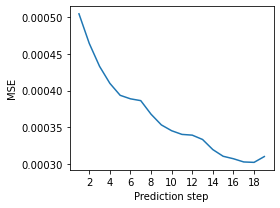

Baseline MSE: 0.00103624
Mean MSE: 0.00084268
average MSE: 0.00036399
Initial MSE: 0.00050410
Final MSE: 0.00031059

Step 1 MSE: 0.00050410
Step 2 MSE: 0.00046395
Step 3 MSE: 0.00043288
Step 4 MSE: 0.00040985
Step 5 MSE: 0.00039362
Step 6 MSE: 0.00038886
Step 7 MSE: 0.00038639
Step 8 MSE: 0.00036798
Step 9 MSE: 0.00035349
Step 10 MSE: 0.00034558
Step 11 MSE: 0.00034062
Step 12 MSE: 0.00033961
Step 13 MSE: 0.00033374
Step 14 MSE: 0.00032000
Step 15 MSE: 0.00031097
Step 16 MSE: 0.00030761
Step 17 MSE: 0.00030325
Step 18 MSE: 0.00030269
Step 19 MSE: 0.00031059



In [15]:
pp = ""

avg_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), ys_pred.shape[2], 1), ys_pred))
init_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, :1]))
final_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, -1:]))

all_mses = []
for i in range(ys_pred.shape[-2]):
    all_mses.append(float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, i:i+1])))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(all_mses)+1), all_mses)
ax.set_xticks(range(2, len(all_mses)+1, 2))
ax.set_xlabel("Prediction step")
ax.set_ylabel("MSE")
fig.tight_layout()
fig.savefig(fdir + "MSE_evolution.pdf")
plt.show()
plt.close()

y0 = torch.zeros_like(ys_trg)
ym = torch.mean(ys_trg, dim=-1).unsqueeze(-1).repeat(1, 1, ys_trg.shape[-1])
baseline_mse = L(ys_trg, y0)
mean_mse = L(ys_trg, ym)

pp = f"Baseline MSE: {baseline_mse:.8f}\nMean MSE: {mean_mse:.8f}\n"
pp += f"average MSE: {avg_mse:.8f}\nInitial MSE: {init_mse:.8f}\nFinal MSE: {final_mse:.8f}\n\n"

for i, mse in enumerate(all_mses):
    pp += f"Step {i+1} MSE: {mse:.8f}\n"
with open(fdir + "results.txt", "w") as F:
    F.write(pp)

plot_comparison(Xs, y_pred, y_std, ys_trg, show=False, save=fdir)
    
print(pp)

# Evaluate 1/wr2, sharp

In [16]:
data_pars = dict(
    # General parameters
    td=256,  # Number of points
    Fs=12800,  # Sampling frequency
    debug=False,  #  Print data generation details
    # Peak parameters
    pmin=1,  # Minimum number of Gaussians in a peak
    pmax=1,  # Maximum number of Gaussians in a peak
    ds=0.03,  # Spread of chemical shift values for each peak
    lw=[[5e1, 2e2]],  # Linewidth range for Gaussians
    iso_p=[1.],
    iso_p_peakwise=True,
    iso_int=[0.5, 1.0],  # Intensity
    phase=0.0,  # Spread of phase
    # Isotropic parameters
    nmin=1,  # Minimum number of peaks
    nmax=15,  # Maximum number of peaks
    shift_range=[2000.0, 10000.0],  # Chemical shift range
    positive=True,  # Force the spectrum to be positive
    # MAS-independent parameters
    # MAS-independent GLS broadening range
    mas0_lw_range=[0.0, 0.0],
    mas0_lw_p=[1.0],
    # MAS-independent GLS mixing paramter
    mas0_m_range=[[0.0, 0.1], [0.0, 1.0]],
    mas0_m_p=[0.8, 0.2],
    mas0_s_range=[0.0, 0.0],  # MAS-independent shift range
    mas0_s_p=[1.0],
    # MAS-dependent parameters
    # MAS-dependent GLS broadening range
    mas_lw_range=[[0., 0.]],
    mas_lw_p=[1.],
    mas_m_range=[[0., 0.]],  # MAS-dependent GLS mixing paramter
    mas_m_p=[1.0],
    mas_s_range=[0., 0.],  # MAS-dependent shift range
    mas_s_p=[1.0],
    # Second-order MAS-dependent parameters
    mas_w2=True,
    mas_w2_p=1.0,
    # Second-order MAS-dependent Gaussian broadening range
    mas2_lw_range=[[1e2, 1e4], [1e8, 1e9]],
    mas2_lw_p=[0.5, 0.5],
    # Second-order MAS-dependent Lorentzian broadening range
    mas2_m_range=[[0.0, 10], [1e4, 1e6]],
    mas2_m_p=[0.5, 0.5],
    # Second-order MAS-dependent shift range
    mas2_s_range=[[0.0, 0.0], [-2e11, 2e11]],
    mas2_s_p=[0.8, 0.2],
    # Other MAS-dependent mixing
    mas_other_mixing_p=0.5,
    mas_other_mixing_trends=["constant", "increase", "decrease"],
    mas_other_mixing_probs=[0.4, 0.3, 0.3],
    mas_other_mixing_range=[0.0, 1.0],
    # Add noise to linewidths
    mas_lw_noise=0.05,
    mas_s_noise=20.0,
    mas_phase=0.01,  # Random phase range for MAS spectra
    peakwise_phase=True,  # Whether the phase should be peak-wise or spectrum-wise
    encode_imag=False,  # Encode the imaginary part of the MAS spectra
    nw=24,  # Number of MAS rates
    mas_w_range=[30000, 100000],  # MAS rate range
    random_mas=True,
    encode_w=True,  # Encode the MAS rate of the spectra
    # Post-processing parameters
    noise=0.0,  # Noise level
    smooth_end_len=10,  # Smooth ends of spectra
    iso_norm=256.0,  #  Normalization factor for peaks
    brd_norm=64.0,  #  Normalization factor for MAS spectra
    offset=0.0,  # Baseline offset
    norm_wr=True,  # Normalize MAS rate values
    wr_inv=False,  # Encode inverse of MAS rate instead of MAS rate
)

fdir = fig_dir + "sharp_1_w2/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [17]:
dataset = data.PIPDatasetGLS(**data_pars)
np.random.seed(123)

In [18]:
Xs = []
ys_trg = []
ys_pred = []

for _ in range(n_batch):
    
    these_Xs = []
    these_ys_trg = []
    
    for _ in range(n_eval):
        X, _, y_trg = dataset.__getitem__(0)
        these_Xs.append(X.unsqueeze(0))
        these_ys_trg.append(y_trg.unsqueeze(0))

    these_Xs = torch.cat(these_Xs)
    these_ys_trg = torch.cat(these_ys_trg)
    
    all_ys = []
    
    with torch.no_grad():
        for i in range(model_pars["batch_input"], data_pars["nw"]+1):
            y_pred, y_std, ys = net(these_Xs[:, :i])
            all_ys.append(ys[:, :, -1:].detach().transpose(0, 1))
        
        
    Xs.append(these_Xs)
    ys_trg.append(these_ys_trg)
    ys_pred.append(torch.cat(all_ys, dim=2))
    
    print(y_pred.shape, y_std.shape, ys.detach().transpose(0, 1).shape)

Xs = torch.cat(Xs)
ys_trg = torch.cat(ys_trg)
ys_pred = torch.cat(ys_pred)
y_pred = torch.mean(ys_pred, dim=1)
y_std = torch.std(ys_pred, dim=1)

torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])


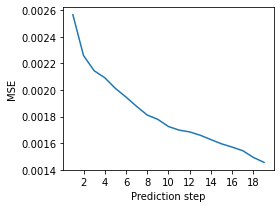

Baseline MSE: 0.00318432
Mean MSE: 0.00300518
average MSE: 0.00181802
Initial MSE: 0.00256730
Final MSE: 0.00145483

Step 1 MSE: 0.00256730
Step 2 MSE: 0.00226022
Step 3 MSE: 0.00214562
Step 4 MSE: 0.00209286
Step 5 MSE: 0.00201261
Step 6 MSE: 0.00194733
Step 7 MSE: 0.00187700
Step 8 MSE: 0.00181169
Step 9 MSE: 0.00177900
Step 10 MSE: 0.00172525
Step 11 MSE: 0.00169820
Step 12 MSE: 0.00168453
Step 13 MSE: 0.00165935
Step 14 MSE: 0.00162649
Step 15 MSE: 0.00159470
Step 16 MSE: 0.00157013
Step 17 MSE: 0.00154286
Step 18 MSE: 0.00149237
Step 19 MSE: 0.00145483



In [19]:
pp = ""

avg_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), ys_pred.shape[2], 1), ys_pred))
init_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, :1]))
final_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, -1:]))

all_mses = []
for i in range(ys_pred.shape[-2]):
    all_mses.append(float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, i:i+1])))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(all_mses)+1), all_mses)
ax.set_xticks(range(2, len(all_mses)+1, 2))
ax.set_xlabel("Prediction step")
ax.set_ylabel("MSE")
fig.tight_layout()
fig.savefig(fdir + "MSE_evolution.pdf")
plt.show()
plt.close()

y0 = torch.zeros_like(ys_trg)
ym = torch.mean(ys_trg, dim=-1).unsqueeze(-1).repeat(1, 1, ys_trg.shape[-1])
baseline_mse = L(ys_trg, y0)
mean_mse = L(ys_trg, ym)

pp = f"Baseline MSE: {baseline_mse:.8f}\nMean MSE: {mean_mse:.8f}\n"
pp += f"average MSE: {avg_mse:.8f}\nInitial MSE: {init_mse:.8f}\nFinal MSE: {final_mse:.8f}\n\n"

for i, mse in enumerate(all_mses):
    pp += f"Step {i+1} MSE: {mse:.8f}\n"
with open(fdir + "results.txt", "w") as F:
    F.write(pp)

plot_comparison(Xs, y_pred, y_std, ys_trg, show=False, save=fdir)
    
print(pp)

# Evaluate 1/wr2, broad

In [20]:
data_pars = dict(
    # General parameters
    td=256,  # Number of points
    Fs=12800,  # Sampling frequency
    debug=False,  #  Print data generation details
    # Peak parameters
    pmin=1,  # Minimum number of Gaussians in a peak
    pmax=1,  # Maximum number of Gaussians in a peak
    ds=0.03,  # Spread of chemical shift values for each peak
    lw=[[1e2, 1e3]],  # Linewidth range for Gaussians
    iso_p=[1.],
    iso_p_peakwise=True,
    iso_int=[0.5, 1.0],  # Intensity
    phase=0.0,  # Spread of phase
    # Isotropic parameters
    nmin=1,  # Minimum number of peaks
    nmax=15,  # Maximum number of peaks
    shift_range=[2000.0, 10000.0],  # Chemical shift range
    positive=True,  # Force the spectrum to be positive
    # MAS-independent parameters
    # MAS-independent GLS broadening range
    mas0_lw_range=[0.0, 0.0],
    mas0_lw_p=[1.0],
    # MAS-independent GLS mixing paramter
    mas0_m_range=[[0.0, 0.1], [0.0, 1.0]],
    mas0_m_p=[0.8, 0.2],
    mas0_s_range=[0.0, 0.0],  # MAS-independent shift range
    mas0_s_p=[1.0],
    # MAS-dependent parameters
    # MAS-dependent GLS broadening range
    mas_lw_range=[0., 0.],
    mas_lw_p=[1.],
    mas_m_range=[[0., 0.]],  # MAS-dependent GLS mixing paramter
    mas_m_p=[1.0],
    mas_s_range=[0., 0.],  # MAS-dependent shift range
    mas_s_p=[1.0],
    # Second-order MAS-dependent parameters
    mas_w2=True,
    mas_w2_p=1.0,
    # Second-order MAS-dependent Gaussian broadening range
    mas2_lw_range=[[1e2, 1e4], [1e8, 1e9]],
    mas2_lw_p=[0.5, 0.5],
    # Second-order MAS-dependent Lorentzian broadening range
    mas2_m_range=[[0.0, 10], [1e4, 1e6]],
    mas2_m_p=[0.5, 0.5],
    # Second-order MAS-dependent shift range
    mas2_s_range=[[0.0, 0.0], [-2e11, 2e11]],
    mas2_s_p=[0.8, 0.2],
    # Other MAS-dependent mixing
    mas_other_mixing_p=0.5,
    mas_other_mixing_trends=["constant", "increase", "decrease"],
    mas_other_mixing_probs=[0.4, 0.3, 0.3],
    mas_other_mixing_range=[0.0, 1.0],
    # Add noise to linewidths
    mas_lw_noise=0.05,
    mas_s_noise=20.0,
    mas_phase=0.01,  # Random phase range for MAS spectra
    peakwise_phase=True,  # Whether the phase should be peak-wise or spectrum-wise
    encode_imag=False,  # Encode the imaginary part of the MAS spectra
    nw=24,  # Number of MAS rates
    mas_w_range=[30000, 100000],  # MAS rate range
    random_mas=True,
    encode_w=True,  # Encode the MAS rate of the spectra
    # Post-processing parameters
    noise=0.0,  # Noise level
    smooth_end_len=10,  # Smooth ends of spectra
    iso_norm=256.0,  #  Normalization factor for peaks
    brd_norm=64.0,  #  Normalization factor for MAS spectra
    offset=0.0,  # Baseline offset
    norm_wr=True,  # Normalize MAS rate values
    wr_inv=False,  # Encode inverse of MAS rate instead of MAS rate
)

fdir = fig_dir + "broad_1_w2/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [21]:
dataset = data.PIPDatasetGLS(**data_pars)
np.random.seed(123)

In [22]:
Xs = []
ys_trg = []
ys_pred = []

for _ in range(n_batch):
    
    these_Xs = []
    these_ys_trg = []
    
    for _ in range(n_eval):
        X, _, y_trg = dataset.__getitem__(0)
        these_Xs.append(X.unsqueeze(0))
        these_ys_trg.append(y_trg.unsqueeze(0))

    these_Xs = torch.cat(these_Xs)
    these_ys_trg = torch.cat(these_ys_trg)
    
    all_ys = []
    
    with torch.no_grad():
        for i in range(model_pars["batch_input"], data_pars["nw"]+1):
            y_pred, y_std, ys = net(these_Xs[:, :i])
            all_ys.append(ys[:, :, -1:].detach().transpose(0, 1))
        
        
    Xs.append(these_Xs)
    ys_trg.append(these_ys_trg)
    ys_pred.append(torch.cat(all_ys, dim=2))
    
    print(y_pred.shape, y_std.shape, ys.detach().transpose(0, 1).shape)

Xs = torch.cat(Xs)
ys_trg = torch.cat(ys_trg)
ys_pred = torch.cat(ys_pred)
y_pred = torch.mean(ys_pred, dim=1)
y_std = torch.std(ys_pred, dim=1)

torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])


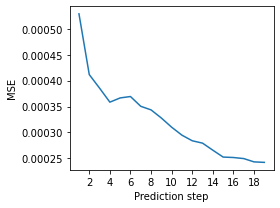

Baseline MSE: 0.00114845
Mean MSE: 0.00095901
average MSE: 0.00032187
Initial MSE: 0.00052907
Final MSE: 0.00024221

Step 1 MSE: 0.00052907
Step 2 MSE: 0.00041171
Step 3 MSE: 0.00038555
Step 4 MSE: 0.00035850
Step 5 MSE: 0.00036666
Step 6 MSE: 0.00036938
Step 7 MSE: 0.00035048
Step 8 MSE: 0.00034356
Step 9 MSE: 0.00032786
Step 10 MSE: 0.00031011
Step 11 MSE: 0.00029472
Step 12 MSE: 0.00028393
Step 13 MSE: 0.00027934
Step 14 MSE: 0.00026572
Step 15 MSE: 0.00025245
Step 16 MSE: 0.00025160
Step 17 MSE: 0.00024953
Step 18 MSE: 0.00024316
Step 19 MSE: 0.00024221



In [23]:
pp = ""

avg_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), ys_pred.shape[2], 1), ys_pred))
init_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, :1]))
final_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, -1:]))

all_mses = []
for i in range(ys_pred.shape[-2]):
    all_mses.append(float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, i:i+1])))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(all_mses)+1), all_mses)
ax.set_xticks(range(2, len(all_mses)+1, 2))
ax.set_xlabel("Prediction step")
ax.set_ylabel("MSE")
fig.tight_layout()
fig.savefig(fdir + "MSE_evolution.pdf")
plt.show()
plt.close()

y0 = torch.zeros_like(ys_trg)
ym = torch.mean(ys_trg, dim=-1).unsqueeze(-1).repeat(1, 1, ys_trg.shape[-1])
baseline_mse = L(ys_trg, y0)
mean_mse = L(ys_trg, ym)

pp = f"Baseline MSE: {baseline_mse:.8f}\nMean MSE: {mean_mse:.8f}\n"
pp += f"average MSE: {avg_mse:.8f}\nInitial MSE: {init_mse:.8f}\nFinal MSE: {final_mse:.8f}\n\n"

for i, mse in enumerate(all_mses):
    pp += f"Step {i+1} MSE: {mse:.8f}\n"
with open(fdir + "results.txt", "w") as F:
    F.write(pp)

plot_comparison(Xs, y_pred, y_std, ys_trg, show=False, save=fdir)
    
print(pp)

# Evaluate 1/wr + 1/wr2, sharp

In [24]:
data_pars = dict(
    # General parameters
    td=256,  # Number of points
    Fs=12800,  # Sampling frequency
    debug=False,  #  Print data generation details
    # Peak parameters
    pmin=1,  # Minimum number of Gaussians in a peak
    pmax=1,  # Maximum number of Gaussians in a peak
    ds=0.03,  # Spread of chemical shift values for each peak
    lw=[[5e1, 2e2]],  # Linewidth range for Gaussians
    iso_p=[1.],
    iso_p_peakwise=True,
    iso_int=[0.5, 1.0],  # Intensity
    phase=0.0,  # Spread of phase
    # Isotropic parameters
    nmin=1,  # Minimum number of peaks
    nmax=15,  # Maximum number of peaks
    shift_range=[2000.0, 10000.0],  # Chemical shift range
    positive=True,  # Force the spectrum to be positive
    # MAS-independent parameters
    # MAS-independent GLS broadening range
    mas0_lw_range=[0.0, 0.0],
    mas0_lw_p=[1.0],
    # MAS-independent GLS mixing paramter
    mas0_m_range=[[0.0, 0.1], [0.0, 1.0]],
    mas0_m_p=[0.8, 0.2],
    mas0_s_range=[0.0, 0.0],  # MAS-independent shift range
    mas0_s_p=[1.0],
    # MAS-dependent parameters
    # MAS-dependent GLS broadening range
    mas_lw_range=[[1e7, 1e8], [5e7, 2e8]],
    mas_lw_p=[0.8, 0.2],
    mas_m_range=[[1e4, 5e4]],  # MAS-dependent GLS mixing paramter
    mas_m_p=[1.0],
    mas_s_range=[-1.5e7, 1.5e7],  # MAS-dependent shift range
    mas_s_p=[1.0],
    # Second-order MAS-dependent parameters
    mas_w2=True,
    mas_w2_p=1.0,
    # Second-order MAS-dependent Gaussian broadening range
    mas2_lw_range=[[1e2, 1e4], [1e8, 1e9]],
    mas2_lw_p=[0.5, 0.5],
    # Second-order MAS-dependent Lorentzian broadening range
    mas2_m_range=[[0.0, 10], [1e4, 1e6]],
    mas2_m_p=[0.5, 0.5],
    # Second-order MAS-dependent shift range
    mas2_s_range=[[0.0, 0.0], [-2e11, 2e11]],
    mas2_s_p=[0.8, 0.2],
    # Other MAS-dependent mixing
    mas_other_mixing_p=0.5,
    mas_other_mixing_trends=["constant", "increase", "decrease"],
    mas_other_mixing_probs=[0.4, 0.3, 0.3],
    mas_other_mixing_range=[0.0, 1.0],
    # Add noise to linewidths
    mas_lw_noise=0.05,
    mas_s_noise=20.0,
    mas_phase=0.01,  # Random phase range for MAS spectra
    peakwise_phase=True,  # Whether the phase should be peak-wise or spectrum-wise
    encode_imag=False,  # Encode the imaginary part of the MAS spectra
    nw=24,  # Number of MAS rates
    mas_w_range=[30000, 100000],  # MAS rate range
    random_mas=True,
    encode_w=True,  # Encode the MAS rate of the spectra
    # Post-processing parameters
    noise=0.0,  # Noise level
    smooth_end_len=10,  # Smooth ends of spectra
    iso_norm=256.0,  #  Normalization factor for peaks
    brd_norm=64.0,  #  Normalization factor for MAS spectra
    offset=0.0,  # Baseline offset
    norm_wr=True,  # Normalize MAS rate values
    wr_inv=False,  # Encode inverse of MAS rate instead of MAS rate
)

fdir = fig_dir + "sharp_1_w1w2/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [25]:
dataset = data.PIPDatasetGLS(**data_pars)
np.random.seed(123)

In [26]:
Xs = []
ys_trg = []
ys_pred = []

for _ in range(n_batch):
    
    these_Xs = []
    these_ys_trg = []
    
    for _ in range(n_eval):
        X, _, y_trg = dataset.__getitem__(0)
        these_Xs.append(X.unsqueeze(0))
        these_ys_trg.append(y_trg.unsqueeze(0))

    these_Xs = torch.cat(these_Xs)
    these_ys_trg = torch.cat(these_ys_trg)
    
    all_ys = []
    
    with torch.no_grad():
        for i in range(model_pars["batch_input"], data_pars["nw"]+1):
            y_pred, y_std, ys = net(these_Xs[:, :i])
            all_ys.append(ys[:, :, -1:].detach().transpose(0, 1))
        
        
    Xs.append(these_Xs)
    ys_trg.append(these_ys_trg)
    ys_pred.append(torch.cat(all_ys, dim=2))
    
    print(y_pred.shape, y_std.shape, ys.detach().transpose(0, 1).shape)

Xs = torch.cat(Xs)
ys_trg = torch.cat(ys_trg)
ys_pred = torch.cat(ys_pred)
y_pred = torch.mean(ys_pred, dim=1)
y_std = torch.std(ys_pred, dim=1)

torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])


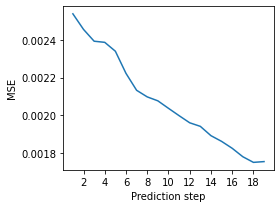

Baseline MSE: 0.00318432
Mean MSE: 0.00300518
average MSE: 0.00207646
Initial MSE: 0.00253815
Final MSE: 0.00175530

Step 1 MSE: 0.00253815
Step 2 MSE: 0.00245569
Step 3 MSE: 0.00239308
Step 4 MSE: 0.00238710
Step 5 MSE: 0.00234004
Step 6 MSE: 0.00222270
Step 7 MSE: 0.00213309
Step 8 MSE: 0.00209811
Step 9 MSE: 0.00207724
Step 10 MSE: 0.00203758
Step 11 MSE: 0.00199863
Step 12 MSE: 0.00196086
Step 13 MSE: 0.00194202
Step 14 MSE: 0.00189265
Step 15 MSE: 0.00186249
Step 16 MSE: 0.00182580
Step 17 MSE: 0.00178113
Step 18 MSE: 0.00175117
Step 19 MSE: 0.00175530



In [27]:
pp = ""

avg_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), ys_pred.shape[2], 1), ys_pred))
init_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, :1]))
final_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, -1:]))

all_mses = []
for i in range(ys_pred.shape[-2]):
    all_mses.append(float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, i:i+1])))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(all_mses)+1), all_mses)
ax.set_xticks(range(2, len(all_mses)+1, 2))
ax.set_xlabel("Prediction step")
ax.set_ylabel("MSE")
fig.tight_layout()
fig.savefig(fdir + "MSE_evolution.pdf")
plt.show()
plt.close()

y0 = torch.zeros_like(ys_trg)
ym = torch.mean(ys_trg, dim=-1).unsqueeze(-1).repeat(1, 1, ys_trg.shape[-1])
baseline_mse = L(ys_trg, y0)
mean_mse = L(ys_trg, ym)

pp = f"Baseline MSE: {baseline_mse:.8f}\nMean MSE: {mean_mse:.8f}\n"
pp += f"average MSE: {avg_mse:.8f}\nInitial MSE: {init_mse:.8f}\nFinal MSE: {final_mse:.8f}\n\n"

for i, mse in enumerate(all_mses):
    pp += f"Step {i+1} MSE: {mse:.8f}\n"
with open(fdir + "results.txt", "w") as F:
    F.write(pp)

plot_comparison(Xs, y_pred, y_std, ys_trg, show=False, save=fdir)
    
print(pp)

# Evaluate 1/wr + 1/wr2, broad

In [28]:
data_pars = dict(
    # General parameters
    td=256,  # Number of points
    Fs=12800,  # Sampling frequency
    debug=False,  #  Print data generation details
    # Peak parameters
    pmin=1,  # Minimum number of Gaussians in a peak
    pmax=1,  # Maximum number of Gaussians in a peak
    ds=0.03,  # Spread of chemical shift values for each peak
    lw=[[1e2, 1e3]],  # Linewidth range for Gaussians
    iso_p=[1.],
    iso_p_peakwise=True,
    iso_int=[0.5, 1.0],  # Intensity
    phase=0.0,  # Spread of phase
    # Isotropic parameters
    nmin=1,  # Minimum number of peaks
    nmax=15,  # Maximum number of peaks
    shift_range=[2000.0, 10000.0],  # Chemical shift range
    positive=True,  # Force the spectrum to be positive
    # MAS-independent parameters
    # MAS-independent GLS broadening range
    mas0_lw_range=[0.0, 0.0],
    mas0_lw_p=[1.0],
    # MAS-independent GLS mixing paramter
    mas0_m_range=[[0.0, 0.1], [0.0, 1.0]],
    mas0_m_p=[0.8, 0.2],
    mas0_s_range=[0.0, 0.0],  # MAS-independent shift range
    mas0_s_p=[1.0],
    # MAS-dependent parameters
    # MAS-dependent GLS broadening range
    mas_lw_range=[[1e7, 1e8], [5e7, 2e8]],
    mas_lw_p=[0.8, 0.2],
    mas_m_range=[[1e4, 5e4]],  # MAS-dependent GLS mixing paramter
    mas_m_p=[1.0],
    mas_s_range=[-1.5e7, 1.5e7],  # MAS-dependent shift range
    mas_s_p=[1.0],
    # Second-order MAS-dependent parameters
    mas_w2=True,
    mas_w2_p=1.0,
    # Second-order MAS-dependent Gaussian broadening range
    mas2_lw_range=[[1e2, 1e4], [1e8, 1e9]],
    mas2_lw_p=[0.5, 0.5],
    # Second-order MAS-dependent Lorentzian broadening range
    mas2_m_range=[[0.0, 10], [1e4, 1e6]],
    mas2_m_p=[0.5, 0.5],
    # Second-order MAS-dependent shift range
    mas2_s_range=[[0.0, 0.0], [-2e11, 2e11]],
    mas2_s_p=[0.8, 0.2],
    # Other MAS-dependent mixing
    mas_other_mixing_p=0.5,
    mas_other_mixing_trends=["constant", "increase", "decrease"],
    mas_other_mixing_probs=[0.4, 0.3, 0.3],
    mas_other_mixing_range=[0.0, 1.0],
    # Add noise to linewidths
    mas_lw_noise=0.05,
    mas_s_noise=20.0,
    mas_phase=0.01,  # Random phase range for MAS spectra
    peakwise_phase=True,  # Whether the phase should be peak-wise or spectrum-wise
    encode_imag=False,  # Encode the imaginary part of the MAS spectra
    nw=24,  # Number of MAS rates
    mas_w_range=[30000, 100000],  # MAS rate range
    random_mas=True,
    encode_w=True,  # Encode the MAS rate of the spectra
    # Post-processing parameters
    noise=0.0,  # Noise level
    smooth_end_len=10,  # Smooth ends of spectra
    iso_norm=256.0,  #  Normalization factor for peaks
    brd_norm=64.0,  #  Normalization factor for MAS spectra
    offset=0.0,  # Baseline offset
    norm_wr=True,  # Normalize MAS rate values
    wr_inv=False,  # Encode inverse of MAS rate instead of MAS rate
)

fdir = fig_dir + "broad_1_w1w2/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [29]:
dataset = data.PIPDatasetGLS(**data_pars)
np.random.seed(123)

In [30]:
Xs = []
ys_trg = []
ys_pred = []

for _ in range(n_batch):
    
    these_Xs = []
    these_ys_trg = []
    
    for _ in range(n_eval):
        X, _, y_trg = dataset.__getitem__(0)
        these_Xs.append(X.unsqueeze(0))
        these_ys_trg.append(y_trg.unsqueeze(0))

    these_Xs = torch.cat(these_Xs)
    these_ys_trg = torch.cat(these_ys_trg)
    
    all_ys = []
    
    with torch.no_grad():
        for i in range(model_pars["batch_input"], data_pars["nw"]+1):
            y_pred, y_std, ys = net(these_Xs[:, :i])
            all_ys.append(ys[:, :, -1:].detach().transpose(0, 1))
        
        
    Xs.append(these_Xs)
    ys_trg.append(these_ys_trg)
    ys_pred.append(torch.cat(all_ys, dim=2))
    
    print(y_pred.shape, y_std.shape, ys.detach().transpose(0, 1).shape)

Xs = torch.cat(Xs)
ys_trg = torch.cat(ys_trg)
ys_pred = torch.cat(ys_pred)
y_pred = torch.mean(ys_pred, dim=1)
y_std = torch.std(ys_pred, dim=1)

torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])
torch.Size([4, 19, 256]) torch.Size([4, 19, 256]) torch.Size([4, 16, 19, 256])


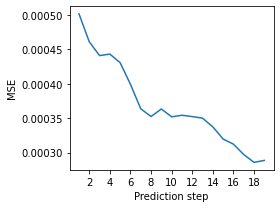

Baseline MSE: 0.00103798
Mean MSE: 0.00087299
average MSE: 0.00036870
Initial MSE: 0.00050183
Final MSE: 0.00028852

Step 1 MSE: 0.00050183
Step 2 MSE: 0.00046116
Step 3 MSE: 0.00044104
Step 4 MSE: 0.00044324
Step 5 MSE: 0.00043067
Step 6 MSE: 0.00039928
Step 7 MSE: 0.00036364
Step 8 MSE: 0.00035240
Step 9 MSE: 0.00036336
Step 10 MSE: 0.00035195
Step 11 MSE: 0.00035423
Step 12 MSE: 0.00035228
Step 13 MSE: 0.00035000
Step 14 MSE: 0.00033727
Step 15 MSE: 0.00031961
Step 16 MSE: 0.00031215
Step 17 MSE: 0.00029709
Step 18 MSE: 0.00028567
Step 19 MSE: 0.00028852



In [31]:
pp = ""

avg_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), ys_pred.shape[2], 1), ys_pred))
init_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, :1]))
final_mse = float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, -1:]))

all_mses = []
for i in range(ys_pred.shape[-2]):
    all_mses.append(float(L(ys_trg.unsqueeze(1).repeat(1, len(net.models), 1, 1), ys_pred[:, :, i:i+1])))

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, len(all_mses)+1), all_mses)
ax.set_xticks(range(2, len(all_mses)+1, 2))
ax.set_xlabel("Prediction step")
ax.set_ylabel("MSE")
fig.tight_layout()
fig.savefig(fdir + "MSE_evolution.pdf")
plt.show()
plt.close()

y0 = torch.zeros_like(ys_trg)
ym = torch.mean(ys_trg, dim=-1).unsqueeze(-1).repeat(1, 1, ys_trg.shape[-1])
baseline_mse = L(ys_trg, y0)
mean_mse = L(ys_trg, ym)

pp = f"Baseline MSE: {baseline_mse:.8f}\nMean MSE: {mean_mse:.8f}\n"
pp += f"average MSE: {avg_mse:.8f}\nInitial MSE: {init_mse:.8f}\nFinal MSE: {final_mse:.8f}\n\n"

for i, mse in enumerate(all_mses):
    pp += f"Step {i+1} MSE: {mse:.8f}\n"
with open(fdir + "results.txt", "w") as F:
    F.write(pp)

plot_comparison(Xs, y_pred, y_std, ys_trg, show=False, save=fdir)
    
print(pp)